In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral

import dataclasses

In [2]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]
print(cpu_device, gpu_device)


TFRT_CPU_0 cuda:0


In [3]:
def routine():
    # physical parameters
    viscosity = 1e-3
    max_velocity = 7
    grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
    dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

    # Forcing function parameters
    wavenumber = 4
    offsets = ((0, 0), (0, 0))
    forcing_func = lambda grid: cfd.forcings.kolmogorov_forcing(grid, k=wavenumber, offsets=offsets)

    # setup step function using crank-nicolson runge-kutta order 4
    smooth = True # use anti-aliasing 
    step_fn = spectral.time_stepping.crank_nicolson_rk4(
        spectral.equations.NavierStokes2D(viscosity, grid, smooth=smooth, forcing_fn=forcing_func), dt)

    # run the simulation up until time 25.0 but only save 10 frames for visualization
    final_time = 25.0
    outer_steps = 10
    inner_steps = (final_time // dt) // 10

    trajectory_fn = cfd.funcutils.trajectory(
        cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

    # create an initial velocity field and compute the fft of the vorticity.
    # the spectral code assumes an fft'd vorticity for an initial state
    v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
    vorticity0 = cfd.finite_differences.curl_2d(v0).data
    vorticity_hat0 = jnp.fft.rfftn(vorticity0)

    _, trajectory = trajectory_fn(vorticity_hat0)
    return trajectory

# Decaying Turbulence

In [4]:
%%time 
# CPU Simulation
with jax.default_device(gpu_device):
    trajectory = routine()


2024-08-20 00:00:40.056833: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


CPU times: user 5.99 s, sys: 616 ms, total: 6.61 s
Wall time: 8.46 s


In [25]:
def linear_forcing(grid, coefficient: float):
  """Linear forcing, proportional to velocity."""
#   del grid
  # print(type(grid), repr(grid))

  def forcing(v):
    print(len(v))
    print('item 1', v[0])
    print('item 2', v[1])
    return tuple(coefficient * u.array for u in v)
  return forcing

In [25]:
%%time 
forcing = True
drag = 0
# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

# Forcing function parameters
wavenumber = 4
offsets = ((0, 0), (0, 0))
# forcing_func = lambda grid: cfd.forcings.kolmogorov_forcing(grid, k=wavenumber, offsets=offsets)
forcing_func = lambda grid: cfd.forcings.transient_flow_forcing(grid, scale=0.1, offsets=offsets)
# forcing_func = lambda grid: linear_forcing(grid, 0.1)
if not forcing:
    forcing_func = None
    
# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing 
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.NavierStokes2D(viscosity, grid, smooth=smooth, forcing_fn=forcing_func, drag=drag), dt)

# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 60.0
outer_steps = 30
inner_steps = (final_time // dt) // outer_steps

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: user 10.6 s, sys: 96.4 ms, total: 10.7 s
Wall time: 11.5 s


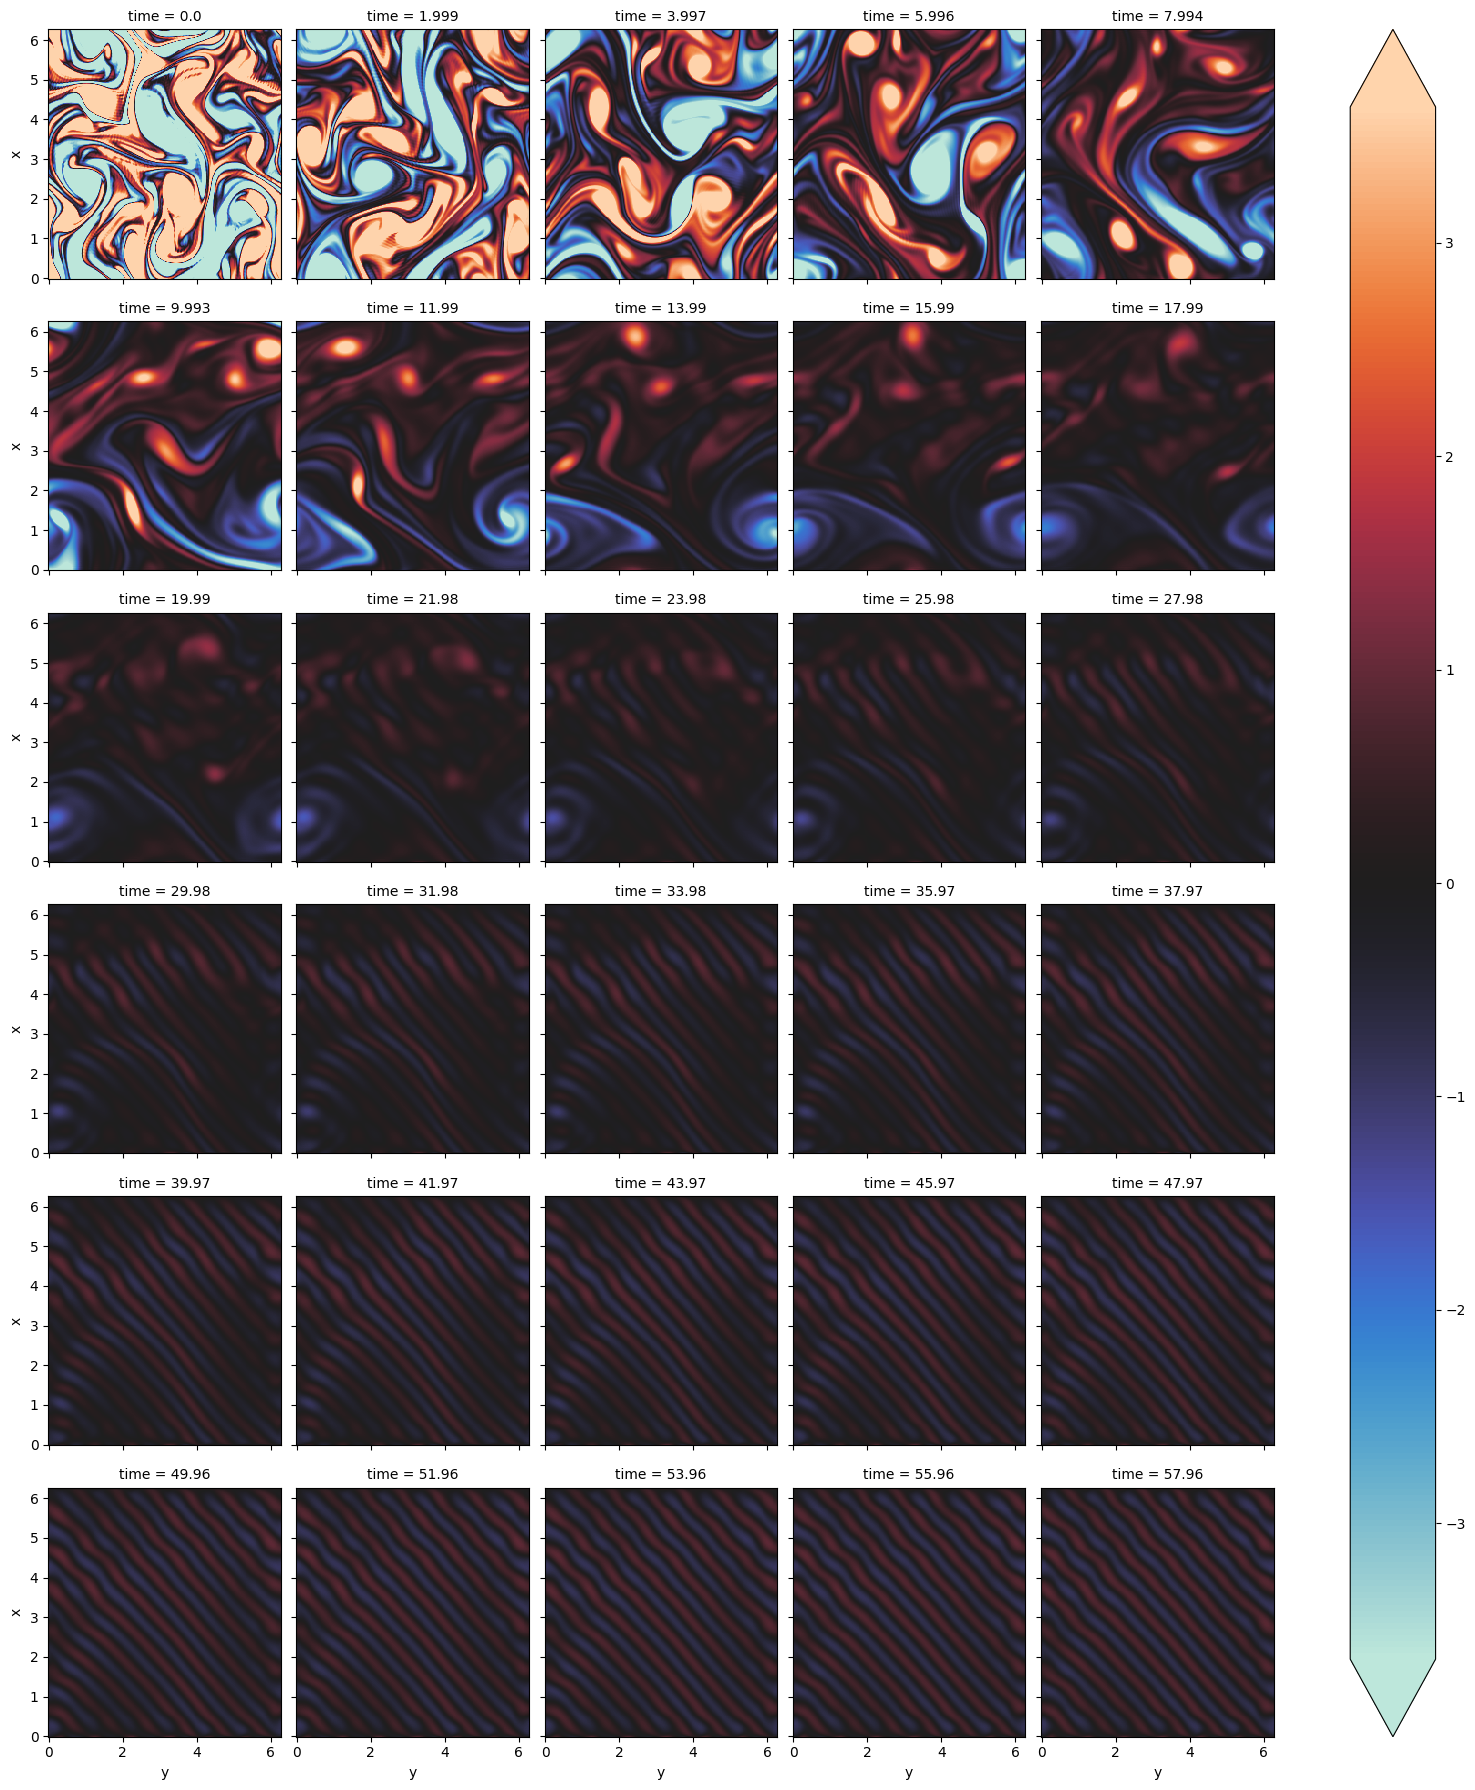

In [26]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

# Forced Turbulence

Same as unforced turbulence (above) except it uses default settings defined in `spectral.equations.ForcedNavierStokes2D`.

In [100]:
%%time 

# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing 


# **use predefined settings for Kolmogorov flow**
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.ForcedNavierStokes2D(viscosity, grid, smooth=smooth), dt)


# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: user 6.2 s, sys: 510 ms, total: 6.71 s
Wall time: 6.63 s


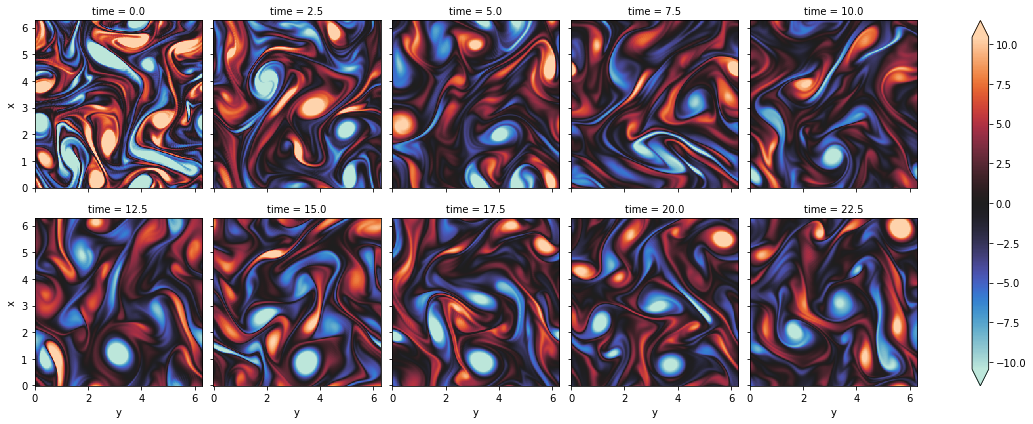

In [101]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);